# Tinder profile generation with RNNs



Part of the Tinder profile generation project
This section handles the profile text generation using LSTMs
we use the kaggle TInder dataset at https://www.kaggle.com/immune/tinder-profiles


Based primary on Brownlees tutorial
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
@author: Adrian

DONT FORGET TO GET RANDOM SEED GEN FROM TRUMP OR BROWNLEE

Brownlees tutorial helps with understanding, but for actual generation, Trump CharRNN is much more useful
https://github.com/jctestud/char-rnn/blob/master/char-rnn_trump_text_generation-TRAINING.ipynb

TLDR: Uses a certain length of chars to predict the next char in a Bio, trained on over 40K Bios

In [0]:
#Import all packages

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import warnings
import sklearn
import io
import scipy
import numpy
import json
import nltk
import sys
import csv
import os
import re
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense

!gdown https://drive.google.com/uc?id=1G5ud0F1DYut4Vcd6WSPrS-CtD8notTSd


Downloading...
From: https://drive.google.com/uc?id=1G5ud0F1DYut4Vcd6WSPrS-CtD8notTSd
To: /content/tinder_data_final.xlsx
3.75MB [00:00, 119MB/s]


In [0]:
#Text import and preprocessing
base_dir = 'tinder_data_final.xlsx'


tinder_profile_df = pd.read_excel(base_dir, error_bad_lines=False, delimiter='\t')

# Print dataframe info
tinder_profile_df.info()

print(tinder_profile_df.head())

# This will print the number of rows and columns that will be used to train
print("Shape of train set : ",tinder_profile_df.shape)

#tinder_profile_df.head()

#Convert dataframe to string already here

tinder_bios_df=tinder_profile_df['Unnamed: 2'].apply(str)



#Print only thhe bios
#print(tinder_bios_df)

#Define a generic vocabulary
# generic vocabulary
characters = list(string.printable)
characters.remove('\x0b')
characters.remove('\x0c')

VOCABULARY_SIZE = len(characters)
characters_to_ix = {c:i for i,c in enumerate(characters)}
print("vocabulary len = %d" % VOCABULARY_SIZE)
print(characters)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60042 entries, 0 to 60041
Data columns (total 4 columns):
5b56c7177d34e24c5c74db22    60042 non-null object
Jany                        60040 non-null object
Unnamed: 2                  43660 non-null object
1991-07-29T16:53:27.285Z    60027 non-null object
dtypes: object(4)
memory usage: 1.8+ MB
   5b56c7177d34e24c5c74db22     Jany  \
0  5a7bc2c82fb5fcca0d3243ef   Brenda   
1  58941a8708ba58e05c2c1d25  Katelyn   
2  5b57f69f7c7c6fca6711513f       Ce   
3  5b55740580c1c36505eb7dfe      Mel   
4  58ba472d208d289b6a1fb406    Mandy   

                                          Unnamed: 2  1991-07-29T16:53:27.285Z  
0                                                NaN  1993-07-29T16:53:27.285Z  
1  I'm just here to meet your dog or cat Snapchat...  1999-07-29T16:53:27.285Z  
2  Me gusta la pizza y lo único que busco aquí so...  1999-07-29T16:53:27.285Z  
3  I’m just a happy hippie. Peace man ✌🏽 It’s all...  1992-07-29T16:53:27.285Z  
4  30 

In [0]:
#Extract individual bios into one large string

#Usually We would pad our sequences, but a quick inspection reveals sequences are drastically different lenghts
#hence lets just join them together.
#We define a filtering function first
holder = []
for i in range(0, len(tinder_bios_df)):
    #print (tinder_bios_df.iloc[i]);
    string = tinder_bios_df.iloc[i]

    if(string== "nan"):
        print("nan removed")
    else:
        holder.append(string)

#print(holder) 

alphaholder= []
regex = re.compile('[^A-Za-z0-9 -.,]')
#now that holder is ready we remove all non alphanumeric entries
for i in range(0, len(holder)):
    string = holder[i]
    
    
    #First parameter is the replacement, second parameter is your input string
    newstring = regex.sub('', string)

    alphaholder.append(newstring)
    
    
#print(alphaholder)

#Split data into train and validation strings
trainholder=[]
validationholder=[]

print(len(alphaholder))
#Len alphaholder is 43660
for i in range(0, 34928): 
    trainstring = alphaholder[i]
    trainholder.append(trainstring)
for i in range(34928, len(alphaholder)): 
    valstring = alphaholder[i]
    validationholder.append(valstring)


#14-04-2019 Data is now ready, need to append into giant string
finalstring = ''.join(trainholder)
validationstring = ''.join(validationholder)

print(finalstring)
print(validationstring)

nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan removed
nan 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Model Building**

In [0]:
#Some variables to set here
N_GPU = 1
# you can experiment with more GPUs, it gets interesting with a high SEQUENCE_LEN
SEQUENCE_LEN = 20; 
#This is the char length of each individual sequence
#Essentially, we use 60 chars to predict the 61st char. This needs to be shorter for us
BATCH_SIZE = 512 #Number of sequences fed at once in batch
EPOCHS = 13
HIDDEN_LAYERS_DIM = 512
LAYER_COUNT = 4
DROPOUT = 0.2

text_train_len = len(finalstring)
text_val_len = len(validationstring)
def describe_batch(X, y, samples=3):
    """Describe in a human-readable format some samples from a batch.  Show the next char given previous char"""
    for i in range(samples):
        sentence = ""
        for s in range(SEQUENCE_LEN):
            sentence += characters[X[i,s,:].argmax()]
        next_char = characters[y[i,:].argmax()]
        
        print("sample #%d: ...%s -> '%s'" % (
            i,
            sentence[-20:],
            next_char
        ))
    
def batch_generator(text, count):
    """Generate batches for training"""
    while True: # keras wants that for reasons
        for batch_ix in range(count):
            X = np.zeros((BATCH_SIZE, SEQUENCE_LEN, VOCABULARY_SIZE))
            y = np.zeros((BATCH_SIZE, VOCABULARY_SIZE))

            batch_offset = BATCH_SIZE * batch_ix

            for sample_ix in range(BATCH_SIZE):
                sample_start = batch_offset + sample_ix
                for s in range(SEQUENCE_LEN):
                    X[sample_ix, s, characters_to_ix[text[sample_start+s]]] = 1
                y[sample_ix, characters_to_ix[text[sample_start+s+1]]]=1

            yield X, y
            


for ix, (X,y) in enumerate(batch_generator(finalstring, count=1)):
    # describe some samples from the first batch
    describe_batch(X, y, samples=5)
    break

sample #0: ...I'm just here to mee -> 't'
sample #1: ...'m just here to meet -> ' '
sample #2: ...m just here to meet  -> 'y'
sample #3: ... just here to meet y -> 'o'
sample #4: ...just here to meet yo -> 'u'


In [0]:
###########################################Model Building#################################
    ###From trump char builder
def build_model(gpu_count=1):
    """Build a Keras sequential model for training the char-rnn"""
    model = Sequential()
    for i in range(LAYER_COUNT):
        model.add(
            LSTM(
                HIDDEN_LAYERS_DIM, 
                return_sequences=True if (i!=(LAYER_COUNT-1)) else False,
                input_shape=(SEQUENCE_LEN, VOCABULARY_SIZE),
            )
        )
        model.add(Dropout(DROPOUT))
    
    model.add(Dense(VOCABULARY_SIZE))
    model.add(Activation('softmax'))
    
    #removed the multigpu line
    
    model.compile(loss='categorical_crossentropy', optimizer="adam")
    return model


training_model = build_model(gpu_count=N_GPU)

train_batch_count = (text_train_len - SEQUENCE_LEN) // BATCH_SIZE
val_batch_count = (text_val_len - SEQUENCE_LEN) // BATCH_SIZE
print("training batch count: %d" % train_batch_count)
print("validation batch count: %d" % val_batch_count)


#NO CHECKPOINTING IN THIS VERSION, because of simplicity and because our dataset is much smaller

training batch count: 8735
validation batch count: 2642


In [0]:
history = training_model.fit_generator(
    batch_generator(finalstring, count=train_batch_count),
    train_batch_count,
    max_queue_size=1, # no more than one queued batch in RAM
    epochs=EPOCHS,
    validation_data=batch_generator(validationstring, count=val_batch_count),
    validation_steps=val_batch_count,
    initial_epoch=0
)
training_model.save('basic_LSTM_tindergenv1_4layers_30char.h5')

Epoch 1/13
8735/8735 [==============================] - 2298s 263ms/step - loss: 1.6185 - val_loss: 1.1585
Epoch 2/13
8735/8735 [==============================] - 2293s 262ms/step - loss: 1.2694 - val_loss: 1.0225
Epoch 3/13
8735/8735 [==============================] - 2294s 263ms/step - loss: 1.2076 - val_loss: 0.9630
Epoch 4/13
8735/8735 [==============================] - 2300s 263ms/step - loss: 1.1772 - val_loss: 0.9347
Epoch 5/13
8735/8735 [==============================] - 2298s 263ms/step - loss: 1.1602 - val_loss: 0.9239
Epoch 6/13
8735/8735 [==============================] - 2298s 263ms/step - loss: 1.1504 - val_loss: 0.9145
Epoch 7/13
8735/8735 [==============================] - 2299s 263ms/step - loss: 1.1446 - val_loss: 0.9116
Epoch 8/13
 726/8735 [=>............................] - ETA: 31:35 - loss: 1.4293Buffered data was truncated after reaching the output size limit.

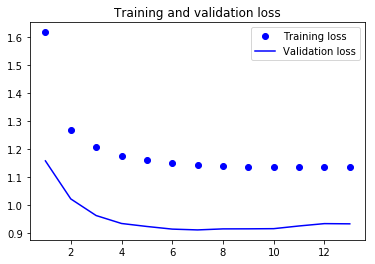

In [0]:
#############################################################################################################3
###After this we can use the trained model to predict things, and view history variables

##Plotting
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()